# Anomaly budget for ECCOv4 temperature (`THETA`, $\theta$)

## Import packages, load data, define terms

In [1]:
import numpy as np
import xarray as xr
import gcsfs
import xgcm

Define LLC face connections for `xgcm.Grid()`

In [2]:
face_connections = {'face':
                    {0: {'X':  ((12, 'Y', False), (3, 'X', False)),
                         'Y':  (None,             (1, 'Y', False))},
                     1: {'X':  ((11, 'Y', False), (4, 'X', False)),
                         'Y':  ((0, 'Y', False),  (2, 'Y', False))},
                     2: {'X':  ((10, 'Y', False), (5, 'X', False)),
                         'Y':  ((1, 'Y', False),  (6, 'X', False))},
                     3: {'X':  ((0, 'X', False),  (9, 'Y', False)),
                         'Y':  (None,             (4, 'Y', False))},
                     4: {'X':  ((1, 'X', False),  (8, 'Y', False)),
                         'Y':  ((3, 'Y', False),  (5, 'Y', False))},
                     5: {'X':  ((2, 'X', False),  (7, 'Y', False)),
                         'Y':  ((4, 'Y', False),  (6, 'Y', False))},
                     6: {'X':  ((2, 'Y', False),  (7, 'X', False)),
                         'Y':  ((5, 'Y', False),  (10, 'X', False))},
                     7: {'X':  ((6, 'X', False),  (8, 'X', False)),
                         'Y':  ((5, 'X', False),  (10, 'Y', False))},
                     8: {'X':  ((7, 'X', False),  (9, 'X', False)),
                         'Y':  ((4, 'X', False),  (11, 'Y', False))},
                     9: {'X':  ((8, 'X', False),  None),
                         'Y':  ((3, 'X', False),  (12, 'Y', False))},
                     10: {'X': ((6, 'Y', False),  (11, 'X', False)),
                          'Y': ((7, 'Y', False),  (2, 'X', False))},
                     11: {'X': ((10, 'X', False), (12, 'X', False)),
                          'Y': ((8, 'Y', False),  (1, 'X', False))},
                     12: {'X': ((11, 'X', False), None),
                          'Y': ((9, 'Y', False),  (0, 'X', False))}}}

Load ECCOv4r3 diagnostic output

In [3]:
gcs = gcsfs.GCSFileSystem(token='anon')
ds = xr.open_zarr(gcsfs.GCSMap('pangeo-data/ecco/eccov4r3', gcs=gcs))

In [4]:
from dask.distributed import Client, progress

from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=20)
cluster

In [5]:
client = Client(cluster)
client

Client Scheduler: tcp://10.22.189.3:42703 Dashboard: /user/jetesdal/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


Number of seconds between each snapshot

In [6]:
dt = ds.time_snp[1:].load()
dt.values = [float(t)/10**9 for t in np.diff(ds.time_snp)]
dt = dt.rename({'time_snp':'time','iter_snp':'iter'})
dt.time.values = ds.time[1:-1].values

Extract coordinates to seperate dataset

In [7]:
coords = ds.coords.to_dataset().reset_coords()
ds = ds.reset_coords(drop=True)

Relevant terms

In [8]:
# Density kg/m^3
rhoconst = 1029

# Heat capacity (J/kg/K)
c_p = 3994

# Constants for surface heat penetration
R = 0.62
zeta1 = 0.6
zeta2 = 20.0

# Ocean depth
Depth = coords.Depth

Grid dimensions

In [9]:
dxG = coords.dxG
dyG = coords.dyG
drF = coords.drF
rA = coords.rA
hFacC = coords.hFacC.load()

Volume

In [10]:
vol = (rA*drF*hFacC).transpose('face','k','j','i')

Mask

In [11]:
# Make copy of hFacC
mskC = hFacC.copy(deep=True).load()

# Change all fractions (ocean) to 1. land = 0
mskC.values[mskC.values>0] = 1

## Diagnostic temperature budget

In [12]:
grid = xgcm.Grid(ds, face_connections=face_connections)

### Tendency

In [13]:
# Load snapshots of THETA and ETAN
THETAsnp = ds.THETA_snp
ETANsnp = ds.ETAN_snp

# Calculate the s∗theta term
HCsnp = (THETAsnp*(1+ETANsnp/Depth)).transpose('time_snp','face','k','j','i')

# Total tendency (degC/s)
tendH = grid.diff(HCsnp, 'T', boundary='fill', fill_value=0.0)/dt

# Add empty arrays for first and last time point
tendH = xr.concat([np.nan*xr.zeros_like(vol).assign_coords(time=ds.time[0]).expand_dims('time'),tendH.drop('iter'),
                   np.nan*xr.zeros_like(vol).assign_coords(time=ds.time[-1]).expand_dims('time')],
                  dim='time').transpose('time','face','k','j','i')

### Forcing

In [14]:
# Load monthly averages of heat flux and shortwave radiation
TFLUX = ds.TFLUX
oceQsw = ds.oceQsw

# Defining terms needed for evaluating surface heat forcing
Z = coords.Z.load()
RF = np.concatenate([coords.Zp1.values[:-1],[np.nan]])
q1 = R*np.exp(1.0/zeta1*RF[:-1]) + (1.0-R)*np.exp(1.0/zeta2*RF[:-1])
q2 = R*np.exp(1.0/zeta1*RF[1:]) + (1.0-R)*np.exp(1.0/zeta2*RF[1:])

# Correction for the 200m cutoff
zCut = np.where(Z < -200)[0][0]
q1[zCut:] = 0
q2[zCut-1:] = 0

# Save q1 and q2 as xarray data arrays
q1 = xr.DataArray(q1,coords=[Z.k],dims=['k'])
q2 = xr.DataArray(q2,coords=[Z.k],dims=['k'])

Surface heat flux

In [15]:
# Compute vertically penetrating flux (surface heat flux below the surface)
forcH_subsurf = ((q1*(mskC==1)-q2*(mskC.shift(k=-1)==1))*oceQsw).transpose('time','face','k','j','i')

# Surface heat flux (at the sea surface)
forcH_surf = ((TFLUX - (1-(q1[0]-q2[0]))*oceQsw)*mskC[0]).transpose('time','face','j','i').assign_coords(k=0).expand_dims('k')

# Full-depth surface forcing
forcH = xr.concat([forcH_surf,forcH_subsurf[:,:,1:]], dim='k').transpose('time','face','k','j','i')

Geothermal heat flux

In [16]:
# Create 3d bathymetry mask
mskC_shifted = mskC.shift(k=-1)
mskC_shifted.values[-1,:,:,:] = 0
mskb = mskC - mskC_shifted

# Create 3d field of geothermal heat flux
geoflx3d = ds.GEOFLX * mskb.transpose('face','k','j','i')
GEOFLX = geoflx3d.transpose('face','k','j','i')

# Add geothermal heat flux to forcing field and convert from W/m^2 to degC/s
forcH = ((forcH + GEOFLX)/(rhoconst*c_p))/(hFacC*drF)

### Advection

In [17]:
ADVxy_diff = grid.diff_2d_vector({'X' : ds.ADVx_TH, 'Y' : ds.ADVy_TH}, boundary = 'fill')
ADVx_diffx = ADVxy_diff['X']
ADVy_diffy = ADVxy_diff['Y']

# Convergence of horizontal advection (degC/s)
adv_hConvH = (-(ADVx_diffx + ADVy_diffy)/vol).transpose('time','face','k','j','i')

# Convergence of vertical advection (degC/s)
ADVr_TH = ds.ADVr_TH.transpose('time','face','k_l','j','i')
adv_vConvH = (grid.diff(ADVr_TH, 'Z', boundary='fill')/vol).transpose('time','face','k','j','i')

### Diffusion

In [18]:
DFxyE_diff = grid.diff_2d_vector({'X' : ds.DFxE_TH, 'Y' : ds.DFyE_TH}, boundary = 'fill')
DFxE_diffx = DFxyE_diff['X']
DFyE_diffy = DFxyE_diff['Y']

# Convergence of horizontal diffusion (degC/s)
dif_hConvH = (-(DFxE_diffx + DFyE_diffy)/vol).transpose('time','face','k','j','i')

# Convergence of vertical diffusion (degC/s)
DFrE_TH = ds.DFrE_TH.transpose('time','face','k_l','j','i')
DFrI_TH = ds.DFrI_TH.transpose('time','face','k_l','j','i')
dif_vConvH = ((grid.diff(DFrE_TH, 'Z', boundary='fill') + \
               grid.diff(DFrI_TH, 'Z', boundary='fill'))/vol).transpose('time','face','k','j','i')

### Save to dataset

In [19]:
varnames = ['tendH','forcH','adv_hConvH','adv_vConvH','dif_hConvH','dif_vConvH']

ds_budg = xr.Dataset(data_vars={})
for varname in varnames:
    ds_budg[varname] = globals()[varname].chunk(chunks={'time':1,'face':13,'k':50,'j':90,'i':90})
    
ds_budg = ds_budg.assign_coords(dt=dt)
ds_budg.dt.attrs = {'units': 's','standard_name': 'dt','coordinate': 'time',
                    'long_name': 'time span between snapshots'}
ds_budg.time.encoding = {}

## Monthly anomaly budget of temperature

Anomaly budget equation:
$$\frac{\partial\theta^{\prime}}{\partial t} + \nabla\cdot(\overline{\mathbf{u}}^m\theta^{\prime}) + \nabla\cdot(\mathbf{u}^{\prime}\overline{\theta}^m) - \nabla \cdot ({\mathbf{u}}^{\prime}\,\theta^{\prime}-\overline{\mathbf{u}^{\prime}\,\theta^{\prime}}^m) = -\nabla \cdot {\mathbf{F_{diff}}}^{\prime} - F_{\textrm{forc}}^{\prime}$$

Remove oceFWflx from WVELMASS

In [20]:
WVELMASS = ds.WVELMASS.transpose('time','face','k_l','j','i')
oceFWflx = ds.oceFWflx.assign_coords(k_l=0).expand_dims('k_l').transpose('time','face','k_l','j','i')
oceFWflx = (oceFWflx/rhoconst)

WVELMASS = xr.concat([WVELMASS.sel(k_l=0) + oceFWflx, WVELMASS[:,:,1:]], 
                     dim='k_l').transpose('time','face','k_l','j','i')

Seperate averages and snapshots

In [21]:
ds_ave = ds[['ETAN','THETA','UVELMASS','VVELMASS','WVELMASS',
             'ADVx_TH','ADVx_SLT','ADVy_TH','ADVy_SLT','ADVr_TH','ADVr_SLT']]

ds_snp = ds[['ETAN_snp','THETA_snp','SALT_snp']].rename({'time_snp':'time'})

Monthly means (climatology)

In [22]:
ds_ave_clim = ds_ave.groupby('time.month').mean('time')
WVELMASS_clim = WVELMASS.groupby('time.month').mean('time')
ds_snp_clim = ds_snp.groupby('time.month').mean('time')
ds_budg_clim = ds_budg.groupby('time.month').mean('time')

Monthly anomalies

In [23]:
ds_ave_anom = ds_ave.groupby('time.month') - ds_ave_clim
WVELMASS_anom = WVELMASS.groupby('time.month') - WVELMASS_clim
ds_snp_anom = ds_snp.groupby('time.month') - ds_snp_clim
ds_budg_anom = ds_budg.groupby('time.month') - ds_budg_clim

### Decomposition of advective fluxes

#### Monthly mean terms

In [24]:
grid = xgcm.Grid(ds_ave_clim, face_connections=face_connections)

# Transport
u_clim = (ds_ave_clim.UVELMASS * coords.dyG * coords.drF).transpose('month','face','k','j','i_g')
v_clim = (ds_ave_clim.VVELMASS * coords.dxG * coords.drF).transpose('month','face','k','j_g','i')
w_clim = (WVELMASS_clim * coords.rA).transpose('month','face','k_l','j','i')

# Potential Temperature (degC)
THETA_clim = ds_ave_clim.THETA.transpose('month','face','k','j','i')
THETA_clim_at_u = grid.interp(THETA_clim, 'X', boundary='extend')
THETA_clim_at_v = grid.interp(THETA_clim, 'Y', boundary='extend')
THETA_clim_at_w = grid.interp(THETA_clim, 'Z', boundary='extend')

#### Monthly anomaly terms

In [25]:
grid = xgcm.Grid(ds_ave_anom, face_connections=face_connections)

# Transport
u_anom = (ds_ave_anom.UVELMASS * coords.dyG * coords.drF).transpose('time','face','k','j','i_g')
v_anom = (ds_ave_anom.VVELMASS * coords.dxG * coords.drF).transpose('time','face','k','j_g','i')
w_anom = (WVELMASS_anom * coords.rA).transpose('time','face','k_l','j','i')

# Temperature
THETA_anom = ds_ave_anom.THETA.transpose('time','face','k','j','i')
THETA_anom_at_u = grid.interp(THETA_anom, 'X', boundary='extend')
THETA_anom_at_v = grid.interp(THETA_anom, 'Y', boundary='extend')
THETA_anom_at_w = grid.interp(THETA_anom, 'Z', boundary='extend')

### Mean advection of anomalous temperature, $\nabla\cdot(\overline{\mathbf{u}}^m\theta^{\prime})$

In [26]:
uclimTanom = u_clim * THETA_anom_at_u.groupby('time.month')
vclimTanom = v_clim * THETA_anom_at_v.groupby('time.month')
wclimTanom = w_clim * THETA_anom_at_w.groupby('time.month')

# Convergence (horizontal)
ADVxy_diff = grid.diff_2d_vector({'X' : uclimTanom, 'Y' : vclimTanom}, boundary = 'fill')
ADVx_diffx = ADVxy_diff['X']
ADVy_diffy = ADVxy_diff['Y']
adv_hConvH_Uclim_Tanom = (-(ADVx_diffx + ADVy_diffy)/vol)

# Convergence (vertical)
adv_vConvH_Uclim_Tanom = (grid.diff(wclimTanom, 'Z', boundary='fill')/vol)

### Anomalous advection of mean temperature, $\nabla\cdot(\mathbf{u}^{\prime}\overline{\theta}^m)$

In [27]:
uanomTclim = u_anom.groupby('time.month') * THETA_clim_at_u
vanomTclim = v_anom.groupby('time.month') * THETA_clim_at_v
wanomTclim = w_anom.groupby('time.month') * THETA_clim_at_w

# Convergence (horizontal)
ADVxy_diff = grid.diff_2d_vector({'X' : uanomTclim, 'Y' : vanomTclim}, boundary = 'fill')
ADVx_diffx = ADVxy_diff['X']
ADVy_diffy = ADVxy_diff['Y']
adv_hConvH_Uanom_Tclim = (-(ADVx_diffx + ADVy_diffy)/vol)

# Convergence (vertical)
adv_vConvH_Uanom_Tclim = (grid.diff(wanomTclim, 'Z', boundary='fill')/vol)

/opt/conda/lib/python3.6/site-packages/dask/array/core.py:3468: PerformanceWarning: Increasing number of chunks by factor of 24
  **atop_kwargs)
/opt/conda/lib/python3.6/site-packages/dask/array/core.py:3468: PerformanceWarning: Increasing number of chunks by factor of 24
  **atop_kwargs)
/opt/conda/lib/python3.6/site-packages/dask/array/core.py:3468: PerformanceWarning: Increasing number of chunks by factor of 24
  **atop_kwargs)
/opt/conda/lib/python3.6/site-packages/dask/array/core.py:3468: PerformanceWarning: Increasing number of chunks by factor of 24
  **atop_kwargs)
/opt/conda/lib/python3.6/site-packages/dask/array/core.py:3468: PerformanceWarning: Increasing number of chunks by factor of 24
  **atop_kwargs)
/opt/conda/lib/python3.6/site-packages/dask/array/core.py:3468: PerformanceWarning: Increasing number of chunks by factor of 24
  **atop_kwargs)
/opt/conda/lib/python3.6/site-packages/dask/array/core.py:3468: PerformanceWarning: Increasing number of chunks by factor of 24
  

### Anomalous advection of anomalous temperature, $\nabla \cdot ({\mathbf{u}}^{\prime}\,\theta^{\prime}-\overline{\mathbf{u}^{\prime}\,\theta^{\prime}}^m)$

In [28]:
uanomTanom = u_anom * THETA_anom_at_u
vanomTanom = v_anom * THETA_anom_at_v
wanomTanom = w_anom * THETA_anom_at_w

uanomTanom_clim = uanomTanom.groupby('time.month').mean('time')
vanomTanom_clim = vanomTanom.groupby('time.month').mean('time')
wanomTanom_clim = wanomTanom.groupby('time.month').mean('time')

uanomTanom_clim_anom = uanomTanom.groupby('time.month') - uanomTanom_clim
vanomTanom_clim_anom = vanomTanom.groupby('time.month') - vanomTanom_clim
wanomTanom_clim_anom = wanomTanom.groupby('time.month') - wanomTanom_clim

# Convergence (horizontal)
ADVxy_diff = grid.diff_2d_vector({'X' : uanomTanom_clim_anom, 'Y' : vanomTanom_clim_anom}, boundary = 'fill')
ADVx_diffx = ADVxy_diff['X']
ADVy_diffy = ADVxy_diff['Y']
adv_hConvH_Uanom_Tanom = (-(ADVx_diffx + ADVy_diffy)/vol)

# Convergence (vertical)
adv_vConvH_Uanom_Tanom = (grid.diff(wanomTanom_clim_anom, 'Z', boundary='fill')/vol)

### Residual (in the advective flux)

In [29]:
grid = xgcm.Grid(ds_ave, face_connections=face_connections)

In [30]:
# Transport
u_transport = (ds_ave.UVELMASS * coords.dyG * coords.drF)
v_transport = (ds_ave.VVELMASS * coords.dxG * coords.drF)
w_transport = (WVELMASS * rA)

# Temperature
THETA = ds_ave.THETA
THETA_at_u = grid.interp(THETA, 'X', boundary='extend')
THETA_at_v = grid.interp(THETA, 'Y', boundary='extend')
THETA_at_w = grid.interp(THETA, 'Z', boundary='extend')

# Advection
uT = (u_transport * THETA_at_u)
vT = (v_transport * THETA_at_v)
wT = (w_transport * THETA_at_w)

# Convergence
ADVxy_diff = grid.diff_2d_vector({'X' : uT, 'Y' : vT}, boundary = 'fill')
ADVx_diffx = ADVxy_diff['X']
ADVy_diffy = ADVxy_diff['Y']
adv_hConvH = (-(ADVx_diffx + ADVy_diffy)/vol).transpose('time','face','k','j','i')
adv_vConvH = (grid.diff(wT, 'Z', boundary='fill')/vol).transpose('time','face','k','j','i')

# Reconstructed
adv_ConvH_reco = adv_hConvH + adv_vConvH

# True (diagnostic)
adv_ConvH_true = ds_budg.adv_hConvH + ds_budg.adv_vConvH

# Residual
adv_ConvH_res = adv_ConvH_true - adv_ConvH_reco
adv_ConvH_res_clim = adv_ConvH_res.groupby('time.month').mean('time')
adv_ConvH_res_anom = adv_ConvH_res.groupby('time.month') - adv_ConvH_res_clim

### Save to dataset

In [31]:
ds = xr.Dataset(data_vars={})

# Tendency
ds['tnd'] = ds_budg_anom.tendH.chunk(chunks={'time':1,'face':13,'k':50,'j':90,'i':90})

# Forcing
ds['frc'] = ds_budg_anom.forcH.chunk(chunks={'time':1,'face':13,'k':50,'j':90,'i':90})

# Mixing
ds['hdif'] = ds_budg_anom.dif_hConvH.chunk(chunks={'time':1,'face':13,'k':50,'j':90,'i':90})
ds['vdif'] = ds_budg_anom.dif_vConvH.chunk(chunks={'time':1,'face':13,'k':50,'j':90,'i':90})

# Advection (Ubar Tprime)
ds['hadv_Uclim_Tanom'] = adv_hConvH_Uclim_Tanom.chunk(chunks={'time':1,'face':13,'k':50,'j':90,'i':90})
ds['vadv_Uclim_Tanom'] = adv_vConvH_Uclim_Tanom.chunk(chunks={'time':1,'face':13,'k':50,'j':90,'i':90})

# Advection (Uprime Tbar)
ds['hadv_Uanom_Tclim'] = adv_hConvH_Uanom_Tclim.chunk(chunks={'time':1,'face':13,'k':50,'j':90,'i':90})
ds['vadv_Uanom_Tclim'] = adv_vConvH_Uanom_Tclim.chunk(chunks={'time':1,'face':13,'k':50,'j':90,'i':90})

# Advection (Uprime Tprime)
ds['hadv_Uanom_Tanom'] = adv_hConvH_Uanom_Tanom.chunk(chunks={'time':1,'face':13,'k':50,'j':90,'i':90})
ds['vadv_Uanom_Tanom'] = adv_vConvH_Uanom_Tanom.chunk(chunks={'time':1,'face':13,'k':50,'j':90,'i':90})

# Residual
ds['res'] = adv_ConvH_res_anom.chunk(chunks={'time':1,'face':13,'k':50,'j':90,'i':90})

## Depth average

In [32]:
np.set_printoptions(formatter={"float_kind": lambda x: "%g" % x})
print(coords.Z.values)

[-5 -15 -25 -35 -45 -55 -65 -75.005 -85.025 -95.095 -105.31 -115.87
 -127.15 -139.74 -154.47 -172.4 -194.735 -222.71 -257.47 -299.93 -350.68
 -409.93 -477.47 -552.71 -634.735 -722.4 -814.47 -909.74 -1007.16 -1105.91
 -1205.54 -1306.2 -1409.15 -1517.09 -1634.18 -1765.14 -1914.15 -2084.03
 -2276.23 -2491.25 -2729.25 -2990.25 -3274.25 -3581.25 -3911.25 -4264.25
 -4640.25 -5039.25 -5461.25 -5906.25]


**Depth of integration**:
- 299.93 m (~300 m)
- 722.4 m (~700 m)
- 2084.03 m (~2000 m)
- 5906.25 m (full-depth)

In [33]:
ds.coords['Z'] = coords.Z
ds.coords['hFacC'] = coords.hFacC
ds.coords['drF'] = coords.drF

In [34]:
ds = ds.swap_dims({'k':'Z'})

In [35]:
z_lower = 2100
print(ds.sel(Z=slice(0,-z_lower)).Z[-1].values)

-2084.035


In [36]:
ds_aveZ = (ds*ds.hFacC*ds.drF).sel(Z=slice(0,-z_lower)).sum('Z')/\
            (ds.hFacC*ds.drF).sel(Z=slice(0,-z_lower)).sum('Z')

### Plot timeseries (tendencies)

In [39]:
import dask

In [38]:
f = 2
j = 42
i = 10

lon = coords.XC[f,j,i].values
lat = coords.YC[f,j,i].values
print(r'Longitude: %.2f,' % lon,'Latitude: %.2f' % lat)

Longitude: -27.50, Latitude: 46.45


In [ ]:
results = dask.compute(ds_aveZ.tnd[:,f,j,i],
                       ds_aveZ.hadv_Uanom_Tclim[:,f,j,i],
                       ds_aveZ.vadv_Uanom_Tclim[:,f,j,i],
                       ds_aveZ.hadv_Uclim_Tanom[:,f,j,i], 
                       ds_aveZ.vadv_Uclim_Tanom[:,f,j,i],
                       ds_aveZ.hdif[:,f,j,i]+ds_aveZ.vdif[:,f,j,i],
                       ds_aveZ.frc[:,f,j,i],
                       ds_aveZ.hadv_Uanom_Tanom[:,f,j,i]+ds_aveZ.vadv_Uanom_Tanom[:,f,j,i],
                       ds_aveZ.res[:,f,j,i])

Rechunk

In [37]:
for varname in ds_aveZ.data_vars:
    ds_aveZ[varname] = ds_aveZ[varname].chunk(chunks={'time':288,'face':1,'j':90,'i':90})

### Integrate over time

In [38]:
ds_intT = (ds_aveZ.isel(time=slice(1, -1))*ds_budg.isel(time=slice(1, -1)).dt).cumsum(dim='time')

In [39]:
ds_intT['time'] = coords.time.isel(time=slice(1, -1))

In [40]:
ds_intT

<xarray.Dataset>
Dimensions:           (face: 13, i: 90, j: 90, time: 286)
Coordinates:
  * time              (time) datetime64[ns] 1992-02-13 1992-03-15 1992-04-14 ...
  * i                 (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                 (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * face              (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    tnd               (time, face, j, i) float64 dask.array<shape=(286, 13, 90, 90), chunksize=(286, 1, 90, 90)>
    frc               (time, face, j, i) float64 dask.array<shape=(286, 13, 90, 90), chunksize=(286, 1, 90, 90)>
    hdif              (time, face, j, i) float64 dask.array<shape=(286, 13, 90, 90), chunksize=(286, 1, 90, 90)>
    vdif              (time, face, j, i) float64 dask.array<shape=(286, 13, 90, 90), chunksize=(286, 1, 90, 90)>
    hadv_Uclim_Tanom  (time, face, j, i) float64 dask.array<shape=(286, 13, 90, 90), chunksize=(286, 1, 90, 90)>
    vadv_Uclim_Tanom  (tim

### Detrend

In [41]:
from scipy import stats

In [42]:
def detrend(y):
    x = np.arange(0,len(y))
    not_nan_ind = ~np.isnan(y)
    if len(x[not_nan_ind]) < 2:
        return np.nan * y
    m, b, r_val, p_val, std_err = stats.linregress(x[not_nan_ind],y[not_nan_ind])
    return  y - (m*x + b)

In [ ]:
ds_intT_dtr = xr.Dataset(data_vars={})
for varname in ds_intT.data_vars:
    ds_intT_dtr[varname] = xr.DataArray(np.apply_along_axis(detrend, 0, 
                                                            ds_intT[varname].transpose('time','face','j','i')),
                                        coords=[ds_intT.time,ds_intT.face,ds_intT.j,ds_intT.i],
                                        dims=['time','face','j','i'])

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

### Correlation analysis

In [ ]:
ds_intT_dtr['dif'] = ds_intT_dtr.hdif + ds_intT_dtr.vdif
ds_intT_dtr['adv_Uanom_Tanom'] = ds_intT_dtr.hadv_Uanom_Tanom + ds_intT_dtr.vadv_Uanom_Tanom

In [ ]:
def get_cov_ratio(x,y):
    y_var = np.var(y[0,0,0],ddof=1)
    cov = np.cov(x[0,0,0], y[0,0,0])[0][1]
    cov_ratio = (cov/y_var).round(2)
    return cov_ratio.reshape(1,1,1)

In [ ]:
ds_corr = xr.Dataset(data_vars={})

# np.errstate(): ignore multiple warnings
# RuntimeWarning: invalid value encountered in true_divide
with np.errstate(invalid='ignore', divide='ignore'):
    
    # Define y (total tendency)
    y = ds_intT_dtr.tnd.transpose('face','j','i','time').chunk(chunks=(1,1,1,-1))

    for varname in ds_intT_dtr.data_vars:
        if (varname == 'tnd' or varname == 'vdif' or varname == 'hdif' \
            or varname == 'hadv_Uanom_Tanom' or varname == 'vadv_Uanom_Tanom' ):
            continue
        
        # Define x (Anomaly budget terms)
        x = ds_intT_dtr[varname].transpose('face','j','i','time').chunk(chunks=(1,1,1,-1))
        
        # Map function across all blocks of a dask array
        cov_ratio = dask.array.map_blocks(get_cov_ratio, x.data, y.data, dtype=np.float64, drop_axis=3)
        
        # Save to dataset
        ds_corr[varname] = xr.DataArray(cov_ratio,coords=[ds_intT_dtr.face,ds_intT_dtr.j,ds_intT_dtr.i],
                                        dims=['face','j','i'])

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline

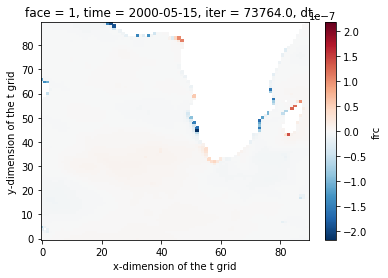

In [67]:
ds_aveZ.frc[100,1].plot()